In [1]:
!pip install seaborn --upgrade

    100% |████████████████████████████████| 215kB 26.3MB/s 
  Found existing installation: seaborn 0.7.1
    Uninstalling seaborn-0.7.1:
      Successfully uninstalled seaborn-0.7.1


# Lecture 16: Line search

Last time we saw that optimization algorithms can sometimes fail pathologically. [Line search](https://en.wikipedia.org/wiki/Line_search) methods help to alleviate this problem. Here, we'll practice implementing the [Wolfe conditions](https://en.wikipedia.org/wiki/Wolfe_conditions), which are a set of inequalities that any optimization step we make should satisfy. 

Let's call the function we're trying to minimize $f(\underline{x})$, and let $\underline{s}$ be the step direction of a proposed update. Let $t$ be the distance that we step in the $\underline{s}$ direction. The Wolfe conditions then require **sufficient decrease** of the function,

$$
f(\underline{x} + t \underline{s}) \leq f(\underline{x}) + \alpha t \nabla f(\underline{x})^T\underline{s}\,,
$$

where $\alpha$ is a parameter that we choose (typically around $10^{-3}$). They also require that the slope of the function decreases significantly, which is captured by a **curvature condition**

$$
\nabla f(\underline{x}+t\underline{s})^T \underline{s} \geq \gamma \nabla f(\underline{x})^T \underline{s}\,.
$$

Here again $\gamma$ is a parameter that we must choose. Naturally, $\gamma\in(\alpha,1)$, and typically $\gamma$ is taken to be between 0.1 and 0.9.


### Example: Correcting steepest descent optimization of a quadratic function

Let's return to the previous example of minimizing a quadratic function with steepest descent, but this time we will apply the Wolfe conditions and a [backtracking line search](https://en.wikipedia.org/wiki/Backtracking_line_search). 

We will consider a quadratic function of a single variable

$$
f(x) = a x^2 + bx + c\,,
$$

with $a>0$. First, let's visualize the function.

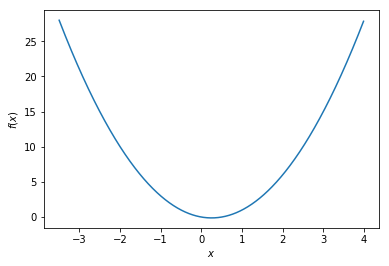

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Define the quadratic function

a =  2
b = -1
c =  0

def f(x):
    return a*x**2 + b*x + c


# Plot the function

x_values = np.arange(-3.5, 4, 0.01)
y_values = f(x_values)

sns.lineplot(x_values, y_values)
plt.xlabel('$x$')
plt.ylabel('$f(x)$');

Like last time, we can compute the derivative 

$$
\nabla f(x) = 2ax + b
$$

and use this to set the steepest descent step direction. 

Above we chose $a=2$, $b=-1$, and $c=0$, so the minimum is located at $x^* = 1/4$.

### Step 1. Compute the step direction

In the code below we will compute the step direction for steepest descent. We'll start by defining a function for the derivative.

In [3]:
def df(x):
    """ Returns the derivative of the quadratic function f(x) = a x^2 + b x + c"""
    return 2*a*x + b


# Choose the step direction

x0 = 3       # Starting value for x
s  = -df(x0) # FILL THIS IN

print(s)

-11


### Step 2. Choose the step length

Last time, we simply set the step length $t=0.1$. This time we will compute it with the backtracking line search. 

As a reminder, this line search iterates through the following steps:

1. Initialize $t=1$
2. Check if **sufficient decrease** condition is satisfied
    - If this check passes, continue
    - If this check fails, set $t = \beta_1 t$ and return to step 2
    
Here we use a parameter $\beta_1<1$ to reduce the step size iteratively until sufficient decrease is satisfied. 

We'll make this algorithm a little more sophisticated by also including a check on the **curvature condition**. This might then be called a "forward-backward" line search:

1. Initialize $t=1$
2. Check if **sufficient decrease** condition is satisfied
   - If this check passes, continue
   - If this check fails, set $t = \beta_1 t$ and return to step 2  
3. Check if **curvature condition** is satisfied
   - If this check passes, continue
   - If this check fails, set $t = \beta_2 t$ and return to step 2  
    
Here, we need to set another parameter $\beta_2>1$. It's important that we also choose $\beta_1, \beta_2$ such that $\beta_1 \beta_2 \neq 1$, otherwise we could get stuck in an infinite loop.

In the example below, we'll choose $\beta_1 = 0.4$, $\beta_2 = 1.2$, $\alpha = 10^{-3}$, and $\gamma = 0.5$.

In [4]:
# Set line search parameters

beta1 = 0.4    # Step size multiplier if sufficient decrease fails
beta2 = 1.2    # Step size multiplier if curvature condition fails
alpha = 0.001  # Sufficient decrease parameter
gamma = 0.5    # Curvature condition parameter

# Initialize step length and adjust until both checks passed

x = x0
t = 1 
both_passed = False

while not both_passed:
    
    # Check for sufficient decrease fail
    
    if f(x + (t*s)) > f(x) + (alpha * t * np.dot(df(x), s)):
        print('\tSufficient decrease failed, reducing t %lf --> %lf' % (t, beta1*t))
        t = beta1 * t
        
    # If passed, check for curvature condition fail
    
    if np.dot(df(x + (t*s)), s) < gamma * np.dot(df(x), s):
        print('\tCurvature condition failed, increasing t %lf --> %lf' % (t, beta2*t))
        t = beta2 * t
        
    # If both passed, exit the loop
    
    else:
        both_passed = True
        
print('\tThe accepted step length is %lf' % t)

	Sufficient decrease failed, reducing t 1.000000 --> 0.400000
	The accepted step length is 0.400000


### Step 3. Update the parameters

The last step in the steepest descent algorithm is to update the parameters. We'll also check for convergence to the minimum by looking at the size of the derivative,

$$
\left|\nabla f(x)\right| < \epsilon\,,
$$

for some suitably small value of $\epsilon$.

**Exercise**: Fill in the code below to find the minimum of $f(x)$ by steepest descent. We'll start at $x_0=3$.

In [5]:
# Set line search parameters

beta1 = 0.4    # Step size multiplier if sufficient decrease fails
beta2 = 1.2    # Step size multiplier if curvature condition fails
alpha = 0.001  # Sufficient decrease parameter
gamma = 0.5    # Curvature condition parameter


# Set steepest descent parameters

epsilon  = 0.001  # Stopping condition -- end when |df/dx| < epsilon 
max_iter = 100    # Maximum number of iterations
it       = 0      # Current iteration


# Initialize and iteratre

x0   = 3      # Starting value of parameter
x    = x0     # Current value of the parameter
dfdx = df(x0) # Starting value of the derivative df/dx

# Report status
print('iter\tx\tf(x)\tdf/dx')

# Now loop through the steepest descent algorithm

while np.fabs(dfdx)>=epsilon and it<max_iter:
    
    # Report status
    print('%d\t%.4f\t%.4f\t%.4f' % (it, x, f(x), dfdx))
    
    # Choose the step direction
    s = -df(x) # FILL THIS IN
    
    # Choose how far to step in that direction
    t = 1 
    both_passed = False
    
    while not both_passed:

        # Check for sufficient decrease fail

        if f(x + (t*s)) > f(x) + (alpha * t * np.dot(df(x), s)):
            print('\tSufficient decrease failed, reducing t %lf --> %lf' % (t, beta1*t))
            t = beta1 * t

        # If passed, check for curvature condition fail

        elif np.dot(df(x + (t*s)), s) < gamma * np.dot(df(x), s):
            print('\tCurvature condition failed, increasing t %lf --> %lf' % (t, beta2*t))
            t = beta2 * t

        # If both passed, exit the loop

        else:
            both_passed = True

    print('\tThe accepted step length is %lf' % t)
    
    # Update the parameters
    x = x + t*s# FILL THIS IN
    
    # Update the derivative
    dfdx = df(x) # FILL THIS IN
    
    # Update the iteration counter
    it += 1
    
# Report the minimum
print('\nFound the minimum near x* = %lf, true minimum is 0.25' % x)

iter	x	f(x)	df/dx
0	3.0000	15.0000	11.0000
	Sufficient decrease failed, reducing t 1.000000 --> 0.400000
	The accepted step length is 0.400000
1	-1.4000	5.3200	-6.6000
	Sufficient decrease failed, reducing t 1.000000 --> 0.400000
	The accepted step length is 0.400000
2	1.2400	1.8352	3.9600
	Sufficient decrease failed, reducing t 1.000000 --> 0.400000
	The accepted step length is 0.400000
3	-0.3440	0.5807	-2.3760
	Sufficient decrease failed, reducing t 1.000000 --> 0.400000
	The accepted step length is 0.400000
4	0.6064	0.1290	1.4256
	Sufficient decrease failed, reducing t 1.000000 --> 0.400000
	The accepted step length is 0.400000
5	0.0362	-0.0335	-0.8554
	Sufficient decrease failed, reducing t 1.000000 --> 0.400000
	The accepted step length is 0.400000
6	0.3783	-0.0921	0.5132
	Sufficient decrease failed, reducing t 1.000000 --> 0.400000
	The accepted step length is 0.400000
7	0.1730	-0.1131	-0.3079
	Sufficient decrease failed, reducing t 1.000000 --> 0.400000
	The accepted step length

### Possible issues, part 2

This time we were able to converge to the minimum even though we started with the same initial conditions as in the previous lecture that resulted in an infinite loop. The line search algorithm led us to convergence. But steepest descent can still fail to converge in reasonable time.

As an example, let's consider a **two-dimensional** quadratic function:

$$
f(\underline{x}) = a_1 x_1^2 + a_2 x_2^2\,.
$$

We'll choose $a_1 = 1$ and $a_2 = 1000$.

In [0]:
a = np.array([1., 1000.])

def f(x):
    return np.sum(a * (x**2))

def df(x):
    return 2*a*x

Now what happens when we try to optimize with steepest descent? We know that the true minimum is at $(0, 0)$. Let's choose the starting point $\underline{x}_0 = (0.9, 0.9)$ and try running the steepest descent algorithm below.

In [7]:
# Set line search parameters

beta1 = 0.4    # Step size multiplier if sufficient decrease fails
beta2 = 1.2    # Step size multiplier if curvature condition fails
alpha = 0.001  # Sufficient decrease parameter
gamma = 0.5    # Curvature condition parameter


# Set steepest descent parameters

epsilon  = 0.001  # Stopping condition -- end when |df/dx| < epsilon 
max_iter = 100    # Maximum number of iterations
it       = 0      # Current iteration


# Initialize and iteratre

x0   = np.array([0.9, 0.9]) # Starting value of parameter
x    = x0                   # Current value of the parameter
dfdx = df(x0)               # Starting value of the derivative df/dx

# Report status
print('iter\tx1\tx2\tf(x)\tdf/dx1\tdf/dx2')

# Now loop through the steepest descent algorithm

while np.sum(np.fabs(dfdx))>=epsilon and it<max_iter:
    
    # Report status
    print('%d\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f' % (it, x[0], x[1], f(x), dfdx[0], dfdx[1]))
    
    # Choose the step direction
    s = -df(x)
    
    # Choose how far to step in that direction
    t = 1 
    both_passed = False
    
    while not both_passed:

        # Check for sufficient decrease fail

        if f(x + (t*s)) > f(x) + (alpha * t * np.dot(df(x), s)):
            #print('\tSufficient decrease failed, reducing t %lf --> %lf' % (t, beta1*t))
            t = beta1 * t

        # If passed, check for curvature condition fail

        elif np.dot(df(x + (t*s)), s) < gamma * np.dot(df(x), s):
            #print('\tCurvature condition failed, increasing t %lf --> %lf' % (t, beta2*t))
            t = beta2 * t

        # If both passed, exit the loop

        else:
            both_passed = True

    #print('\tThe accepted step length is %lf' % t)
    
    # Update the parameters
    x = x + t*s
    
    # Update the derivative
    dfdx = df(x)
    
    # Update the iteration counter
    it += 1
    
# Report the minimum
print('\nFound the minimum near x* = (%lf, %lf), true minimum is (0, 0)' % (x[0], x[1]))

iter	x1	x2	f(x)	df/dx1	df/dx2
0	0.900	0.900	810.810	1.800	1800.000
1	0.899	-0.280	79.011	1.798	-559.296
2	0.898	0.087	8.356	1.795	173.784
3	0.896	-0.027	1.533	1.793	-53.998
4	0.895	0.008	0.872	1.791	16.778
5	0.894	-0.003	0.806	1.788	-5.213
6	0.893	0.001	0.798	1.786	1.620
7	0.890	-0.002	0.796	1.780	-3.688
8	0.889	0.001	0.790	1.778	1.146
9	0.886	-0.001	0.787	1.772	-2.609
10	0.885	0.000	0.783	1.770	0.811
11	0.878	-0.003	0.779	1.755	-5.831
12	0.876	0.001	0.769	1.753	1.812
13	0.874	-0.002	0.767	1.747	-4.125
14	0.872	0.001	0.761	1.745	1.282
15	0.870	-0.001	0.758	1.739	-2.918
16	0.868	0.000	0.754	1.737	0.907
17	0.861	-0.003	0.752	1.723	-6.521
18	0.860	0.001	0.741	1.720	2.026
19	0.857	-0.002	0.740	1.715	-4.613
20	0.856	0.001	0.734	1.712	1.433
21	0.853	-0.002	0.731	1.707	-3.264
22	0.852	0.001	0.727	1.705	1.014
23	0.849	-0.001	0.723	1.699	-2.309
24	0.848	0.000	0.720	1.697	0.717
25	0.841	-0.003	0.715	1.683	-5.160
26	0.840	0.001	0.707	1.681	1.603
27	0.838	-0.002	0.705	1.675	-3.650
28	0.836	0.001	0

Again, we've fallen into a trap! This is due to the vast difference in **curvature** between these two directions. Next time we will discuss another method to avoid this kind of issue.